In [39]:
from sndstraj.utils.helpers import start_sc
from sndstraj.utils.helpers import build_vocabulary
from sndstraj.eventsTransformers.pmiMatrix import build_cooccurrence_matrix

from pyspark.ml.feature import CountVectorizer
import pyspark.ml.feature as ml_feature
from pyspark.mllib.linalg import DenseVector
from pyspark.sql import DataFrame
from pyspark.sql import Window
import pyspark.sql.functions as func
from pyspark.sql.types import (StructField, StringType, StructType, DoubleType, TimestampType)


import pandas as pd
from itertools import chain
import numpy as np
from typing import List

In [2]:
sqlContext = start_sc(4)

In [3]:
path2data = "../../studies/template/data/raw_data/sample10K.parquet"
path2preprocessed = "../../studies/template/data/preprocessed10K"

In [40]:
test_events_df = pd.DataFrame({
    'patientID': ['p1', 'p1', 'p1', 'p1', 'p3', 'p3'],
    'category': ['drug', 'drug', 'mco_main_diagnosis', 'mco_main_diagnosis', 'drug', 'mco_main_diagnosis'],
    'value': ['A10AB01', 'A10AB02', 'E11', 'A10AB01', 'A10AB01', 'E11'],
    'groupID': ['10000', '10000', '10000', '10000', '10000', '10000'],
    'weight': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'start': ['2019-01-01', '2019-01-10', '2019-01-11', '2019-03-05', '2019-06-01', '2019-07-01'],
    'end': ['2019-01-01', '2019-01-10', '2019-01-11', '2019-03-05', '2019-06-01', '2019-07-01']},
)

test_events_df['start'] = pd.to_datetime(test_events_df['start'])
test_events_df['end'] = pd.to_datetime(test_events_df['end'])

data_schema = [
    StructField('patientID', StringType(), True),
    StructField('category', StringType(), True),
    StructField('value', StringType(), True),
    StructField('groupID', StringType(), True),
    StructField('weight', DoubleType(), True),
    StructField('start', TimestampType(), True),
    StructField('end', TimestampType(), True)]

final_struc = StructType(fields=data_schema)

In [41]:
#events = sqlContext.read.parquet(path2data)
events = sqlContext.createDataFrame(test_events_df, schema=final_struc)
events.show(7)

+---------+------------------+-------+-------+------+-------------------+-------------------+
|patientID|          category|  value|groupID|weight|              start|                end|
+---------+------------------+-------+-------+------+-------------------+-------------------+
|       p1|              drug|A10AB01|  10000|   0.0|2019-01-01 00:00:00|2019-01-01 00:00:00|
|       p1|              drug|A10AB02|  10000|   0.0|2019-01-10 00:00:00|2019-01-10 00:00:00|
|       p1|mco_main_diagnosis|    E11|  10000|   0.0|2019-01-11 00:00:00|2019-01-11 00:00:00|
|       p1|mco_main_diagnosis|A10AB01|  10000|   0.0|2019-03-05 00:00:00|2019-03-05 00:00:00|
|       p3|              drug|A10AB01|  10000|   0.0|2019-06-01 00:00:00|2019-06-01 00:00:00|
|       p3|mco_main_diagnosis|    E11|  10000|   0.0|2019-07-01 00:00:00|2019-07-01 00:00:00|
+---------+------------------+-------+-------+------+-------------------+-------------------+



In [5]:
#### with my fucntion coompute vocabulary (unnecessary)
#label2ix, _ = build_vocabulary(events_with_boundaries)
#mapping_expr = func.create_map([func.lit(x) for x in chain(*label2ix.items())])
#events_with_ix_codes = events_with_boundaries.withColumn("vocabulary_ix", mapping_expr.getItem(func.col("value")).cast("string"))

In [6]:
#co_occ_30d_centered = build_cooccurrence_matrix(events=events, window_in_days=30, window_orientation='future')

-----Fit count vectorizer model-----
Vocabulary of length 47
-----Transform events with count vectorizer model-----
-----Collect co-occurrence matrix as pandas-----


In [46]:
def days_to_seconds(days: int) -> int:
    return days * 86400

def join_lists(list_2d: List[List[str]]) -> List[str]:
    return list(chain(*list_2d))

radius_in_days = 30
window_orientation = 'centered'

In [47]:
radius_in_seconds = days_to_seconds(radius_in_days)
window_start = - radius_in_seconds
window_end = radius_in_seconds

In [48]:
w = Window.partitionBy('patientID').orderBy(
    func.col('start').cast('long')).rangeBetween(
    window_start, window_end)
events_in_window = events.withColumn(
    'start', func.col('start').cast('long')).withColumn(
    'cooccurrence', func.collect_list(func.col('value')).over(w))

In [49]:
events_in_window.show(10, False)

+---------+------------------+-------+-------+------+----------+-------------------+-----------------------+
|patientID|category          |value  |groupID|weight|start     |end                |cooccurrence           |
+---------+------------------+-------+-------+------+----------+-------------------+-----------------------+
|p3       |drug              |A10AB01|10000  |0.0   |1559340000|2019-06-01 00:00:00|[A10AB01, E11]         |
|p3       |mco_main_diagnosis|E11    |10000  |0.0   |1561932000|2019-07-01 00:00:00|[A10AB01, E11]         |
|p1       |drug              |A10AB01|10000  |0.0   |1546297200|2019-01-01 00:00:00|[A10AB01, A10AB02, E11]|
|p1       |drug              |A10AB02|10000  |0.0   |1547074800|2019-01-10 00:00:00|[A10AB01, A10AB02, E11]|
|p1       |mco_main_diagnosis|E11    |10000  |0.0   |1547161200|2019-01-11 00:00:00|[A10AB01, A10AB02, E11]|
|p1       |mco_main_diagnosis|A10AB01|10000  |0.0   |1551740400|2019-03-05 00:00:00|[A10AB01]              |
+---------+--------

In [ ]:
codes_vectorizer = ml_feature.CountVectorizer(
    inputCol="cooccurrence",
    outputCol="cooccurrence_ohe",
    minDF=0)

if verbose:
    print('-----Fit count vectorizer model-----')
codes_vectorizer_model = codes_vectorizer.fit(events_in_window)
if verbose:
    print('Vocabulary of length {}'.format(len(codes_vectorizer_model.vocabulary)))
if verbose:
    print('-----Transform events with count vectorizer model-----')
events_ohe = codes_vectorizer_model.transform(events_in_window)
label2ix = {label: i for (label, i) in zip(codes_vectorizer_model.vocabulary,
                                           range(len(codes_vectorizer_model.vocabulary)))}
# adding ix for future reduced key
mapping_expr = func.create_map([func.lit(x) for x in chain(*label2ix.items())])
events_ohe_with_ix = events_ohe.withColumn(
    'ix', mapping_expr.getItem(func.col("value")).cast("int"))
# sort by item ix and get back raw counts (suppres
# s item ignored by count vectorizer)
item_count = np.array(
    events_ohe_with_ix.groupBy('ix').count().filter(
        ~func.col('ix').isNull()).sort(func.col('ix')).drop('ix').collect()).reshape(
    -1)

# aggregate one line per item and sort by item index
events_ohe_grouped = events_ohe_with_ix.select('ix', 'cooccurrence_ohe').rdd.mapValues(
    lambda v: v.toArray()).reduceByKey(
    lambda x, y: x + y).mapValues(
    lambda x: DenseVector(x)).toDF(["ix", "cooccurrence_ohe"])
# remove excluded code from count_vectorizer and sort by ix
events_ohe_grouped_sorted = events_ohe_grouped.filter(
    ~func.col('ix').isNull()).sort(func.col('ix').asc())
# collect and reshape the cooccurrence matrix
if matrix_type == 'pandas':
    if verbose:
        print('-----Collect co-occurrence matrix as pandas-----')
    x_3d = np.array(events_ohe_grouped_sorted.select('cooccurrence_ohe').collect())
    rows, idx, vocab_size = x_3d.shape
    cooccurrence_matrix = x_3d.reshape(rows, rows) - np.diag(item_count)

## Old code

In [19]:
# convert days into timesecond
days = lambda i: i * 86400
# little hack of the rangeBetween function
w = Window.partitionBy('patientID').orderBy(func.col('start').cast('long')).rangeBetween(-days(15), days(15))
## adding a long timestamp
events_w_delay = events.withColumn('start_as_second', func.col('start').cast('long'))
events_in_window = events_w_delay.withColumn(
    'cooccurrence', func.collect_list(func.col('value')).over(w)).withColumn(
    'delay', func.collect_list(func.col('start_as_second')).over(w))
events_in_window.show(3, False)

+---------+---------------+-------------+--------+------+-------------------+----+---------------+---------------------------------------------------+------------------------------------------------------------+
|patientID|category       |value        |groupID |weight|start              |end |start_as_second|cooccurrence                                       |delay                                                       |
+---------+---------------+-------------+--------+------+-------------------+----+---------------+---------------------------------------------------+------------------------------------------------------------+
|pID-1039 |drug           |3400949502479|pfsID-59|0.0   |2017-02-07 01:00:00|null|1486425600     |[3400949502479]                                    |[1486425600]                                                |
|pID-1039 |drug           |3400933468804|pfsID-56|0.0   |2017-03-05 01:00:00|null|1488672000     |[3400933468804, J440, J449, GLQP014, 3400934060335]|[1

In [51]:
def my_gaussian_pdf(x, mu, sigma=1):
    return np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)

from scipy.stats import norm

In [ ]:
norm()

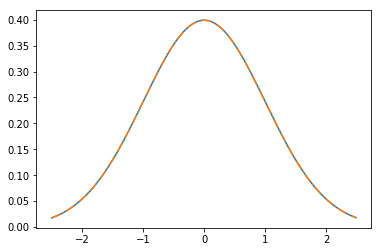

In [56]:
# pdf verification
import matplotlib.pyplot as plt
xx = np.arange(-2.5, 2.5, 0.01)
yy = gaussian_pdf(xx, 0)
gg = norm.pdf(xx, loc=0, scale=1)
plt.plot(xx, yy)
plt.plot(xx, gg, linestyle='-.')

In [45]:
## adding centered gaussian 
import numpy as np

def add_weight(dates: np.array, ref_date: np.int64, sigma: float = 1.0):
    delays = gaussian_pdf(dates, mu=ref_date, sigma=sigma)
    return delays

#events_in_window_weighted = 

In [48]:
## test udf
dates = np.array([1488672000, 1488672000, 1489017600, 1489276800, 1489708800])

add_weight(dates, ref_date=1488672000, sigma=15*86400)

array([3.07825834e-07, 3.07825834e-07, 2.97073206e-07, 2.76067461e-07,
       2.23527433e-07])

In [9]:
from itertools import chain
from typing import List
from pyspark.sql.types import ArrayType, StringType

def join_lists(list_2d: List[List[str]]) -> List[str]:
    return list(chain(*list_2d))

join_lists_udf = func.udf(join_lists, ArrayType(StringType()))

In [10]:
# aggregate by value
#events_aggregate = events_in_window.groupBy('value').agg(join_lists_udf(func.collect_list(func.col('cooccurrence'))).alias('cooccurrence_grouped_by_code'))

In [12]:
#codesVectorizer = CountVectorizer(inputCol="cooccurrence_grouped_by_code", outputCol="cooccurrence_ohe", minDF=1.0)
codesVectorizer = CountVectorizer(inputCol="cooccurrence", outputCol="cooccurrence_ohe", minDF=1.0)

In [13]:
codesVectorizer_model = codesVectorizer.fit(events_in_window)
label2ix = {label: i for (label, i) in zip(codesVectorizer_model.vocabulary,
                                               range(len(codesVectorizer_model.vocabulary)))}

In [14]:
from itertools import chain
from pyspark.sql.functions import create_map, lit, col

In [15]:
events_ohe = codesVectorizer_model.transform(events_in_window)

# adding ix
mapping_expr = create_map([lit(x) for x in chain(*label2ix.items())])

events_ohe_with_ix = events_ohe.withColumn(
    'ix', mapping_expr.getItem(col("value")).cast("int"))
    
events_ohe_with_ix.select('ix', 'value', 'cooccurrence_ohe').show(5, False)

+---+--------------------------------------------------+----------------------------+
|ix |value                                             |cooccurrence_ohe            |
+---+--------------------------------------------------+----------------------------+
|4  |J960                                              |(20,[4],[1.0])              |
|3  |J181                                              |(20,[3,9],[1.0,1.0])        |
|9  |Anti_IgE                                          |(20,[3,9,16],[1.0,1.0,1.0]) |
|16 |Antibiotiques                                     |(20,[9,12,16],[1.0,1.0,1.0])|
|12 |Bronchodilatateurs_Adrenergiques_anticolinergiques|(20,[12,16],[1.0,1.0])      |
+---+--------------------------------------------------+----------------------------+
only showing top 5 rows



In [16]:
from pyspark.mllib.linalg import DenseVector
events_ohe_grouped = events_ohe_with_ix.select('ix', 'cooccurrence_ohe').rdd.mapValues(
    lambda v: v.toArray()).reduceByKey(
    lambda x, y: x + y).mapValues(
    lambda x: DenseVector(x)).toDF(["value", "cooccurrence_ohe"])


In [18]:
import numpy as np
item_count = np.array(events_ohe_with_ix.groupBy('ix').count().sort(func.col('ix')).drop('ix').collect()).reshape(-1)
item_count

array([11349, 11159, 11053, 10991, 11066, 11034,  9707,  9664,  9678,
        9594,  9629,  9600,  9544,  9462,  9513,  9452,  9493,  9445,
        9389,  9360])

In [46]:
events_ohe_grouped.show(20)

+-----+--------------------+
|value|    cooccurrence_ohe|
+-----+--------------------+
|    0|[12461.0,1022.0,1...|
|    1|[1022.0,12217.0,9...|
|    2|[1077.0,986.0,121...|
|    3|[1083.0,1030.0,10...|
|    4|[1085.0,1001.0,10...|
|    5|[999.0,1046.0,977...|
|    6|[963.0,885.0,906....|
|    7|[907.0,905.0,897....|
|    8|[875.0,933.0,888....|
|    9|[935.0,893.0,871....|
|   10|[897.0,848.0,905....|
|   11|[880.0,889.0,866....|
|   12|[886.0,884.0,897....|
|   13|[889.0,886.0,901....|
|   14|[903.0,938.0,889....|
|   15|[909.0,898.0,849....|
|   16|[857.0,953.0,837....|
|   17|[855.0,857.0,865....|
|   18|[868.0,853.0,844....|
|   19|[881.0,844.0,860....|
+-----+--------------------+



In [47]:
import numpy as np
x_3d = np.array(events_ohe_grouped.select('cooccurrence_ohe').collect())

In [48]:
print(x_3d.shape)
rows, idx, vocabsize = x_3d.shape
X = x_3d.reshape(rows, rows) - np.diag(item_count)
print(X.shape)
X

(20, 1, 20)
(20, 20)


array([[1112., 1022., 1077., 1083., 1085.,  999.,  963.,  907.,  875.,
         935.,  897.,  880.,  886.,  889.,  903.,  909.,  857.,  855.,
         868.,  881.],
       [1022., 1058.,  986., 1030., 1001., 1046.,  885.,  905.,  933.,
         893.,  848.,  889.,  884.,  886.,  938.,  898.,  953.,  857.,
         853.,  844.],
       [1077.,  986., 1070., 1056., 1034.,  977.,  906.,  897.,  888.,
         871.,  905.,  866.,  897.,  901.,  889.,  849.,  837.,  865.,
         844.,  860.],
       [1083., 1030., 1056., 1044.,  988., 1013.,  898.,  942.,  839.,
         868.,  905.,  889.,  877.,  865.,  870.,  873.,  879.,  793.,
         864.,  874.],
       [1085., 1001., 1034.,  988.,  992., 1003.,  910.,  852.,  857.,
         927.,  852.,  871.,  883.,  840.,  865.,  848.,  836.,  863.,
         838.,  856.],
       [ 999., 1046.,  977., 1013., 1003.,  948.,  894.,  896.,  910.,
         893.,  857.,  840.,  876.,  862.,  874.,  823.,  858.,  871.,
         840.,  788.],
       [ 9

## trying to sum one hot encoding from spark ml (see above)

## Plot figure

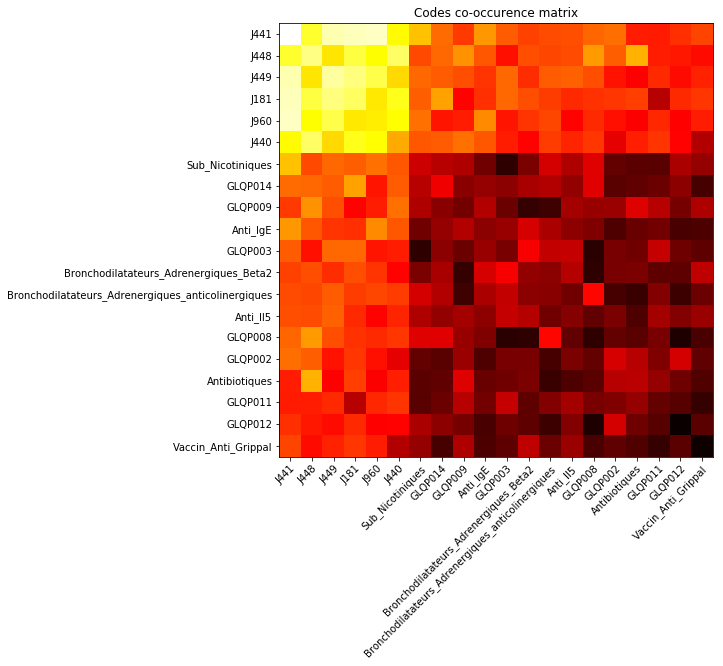

In [51]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(10, 10))

labels = label2ix.keys()
plt.imshow(X, cmap='hot', interpolation='nearest')

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_title("Codes co-occurence matrix")
fig.tight_layout()

plt.show()